# Day 3 - polygons

Sources:
- Pubs from OpenStreetMap via [Overpass API](https://overpass-turbo.eu/)
- Grid of London (see [this notebook](https://github.com/Lisa-Ho/30-day-map-challenge/blob/main/2022/Day12/london-gridmaps.ipynb) for a guide on how to make fishnet grids)

## Setup

In [4]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import json
import pandas as pd

import matplotlib.pyplot as plt

#for legends
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import math
from matplotlib.lines import Line2D

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

In [15]:
# custom fonts
from matplotlib import font_manager
plt.rcParams['font.family'] = ['FreeSans']
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\coolvetica rg.otf')

## Load data

In [ ]:
_crs = 'EPSG:32630'

In [159]:
# pre made 1skm grid
fishnet = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'fishnets\\london-1000-1000.geojson'))

# read London shapefile and reproject to coordinate system to match grid
london_all = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson'))
london_all = london_all.to_crs(_crs)

# load river shapefile
river = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'london-shapefiles\\river-thames-clipped.geojson'))
river = river.to_crs(_crs)

In [5]:
# get pubs from OSM using Overpass API
overpass_url = 'http://overpass-api.de/api/interpreter'
overpass_query = '''
[out:json];
area[name='Greater London'][admin_level=5]->.searchArea;

(way['amenity'='pub'](area.searchArea);  
node['amenity'='pub'](area.searchArea);  
rel['amenity'='pub'](area.searchArea); 
);
out center;

'''
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [13]:
# convert json into dataframe
df_dict = {'id':[], 'type': [], 'lat':[], 'lon': [],'name':[], 'brewery':[], 'outdoor_seating':[]}

for element in data['elements']:
    df_dict['id'].append(element['id'])
    df_dict['type'].append(element['type'])
    
    for tag in list(df_dict.keys())[4:]:
        try:
            df_dict[tag].append(element['tags'][tag])
        except KeyError:
            df_dict[tag].append('') 
    if element['type']=='node':
        df_dict['lat'].append(element['lat'])
        df_dict['lon'].append(element['lon'])
    else:
        df_dict['lat'].append(element['center']['lat'])
        df_dict['lon'].append(element['center']['lon'])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [161]:
 #merge data to fishnet
gdf = gdf.to_crs(_crs)
merged = gpd.sjoin(gdf, fishnet, how='left')

# make a count variable that we can sum per grid cell
merged['pubs']=1
dissolve = merged.dissolve(by='index_right', aggfunc='count')

# include count in fishnet
fishnet.loc[dissolve.index, 'pubs'] = dissolve['pubs'].values

In [130]:
# dictionary of places to map
places = { 'Liverpool St': [51.517633137766545, -0.08060437959423257],
             'Camden': [51.53955149862139, -0.14262241669039177],
             'Soho': [51.51309688360682, -0.13491248421579607],
             'Hammersmith': [51.49223618549943, -0.22361215911733306],
             'Kingston':[51.41005356527376, -0.30761369381871223],
             'Clapham':[51.46175333629983, -0.13824969876097923],
             'Greenwich':[51.48121009775496, -0.008821993203704328],
             'Stoke Newington': [51.563288633155686, -0.07362390972736396],
             'Richmond':[51.45930825530233, -0.3056528356679942],
             'Peckham': [51.46972165892539, -0.0677932533736561],
             'Bromley': [51.404040001513586, 0.016439934862091166],
             'Sutton': [51.36439196566658, -0.19218816484096937],
             'Croydon':[51.374244431071716, -0.10021148332449809],
             'Finchley':[51.61244855213473, -0.17340662821177052],
             'Ealing':[51.51422792569118, -0.29740243602398153],
             'Uxbridge':[51.54588351354679, -0.48054039984798463],
             'Barnet':[51.65517939596126, -0.2030428834136167],
             'Finsbury':[51.56021525548463, -0.11988395868153044],
             'Stratford':[51.54248675328208, 0.005191726952792273]
         }
places = pd.DataFrame.from_dict(places, orient='index', columns=['lat', 'lon'])
geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = '4326', geometry = geometry)
places = places.to_crs(_crs)

## Visualise

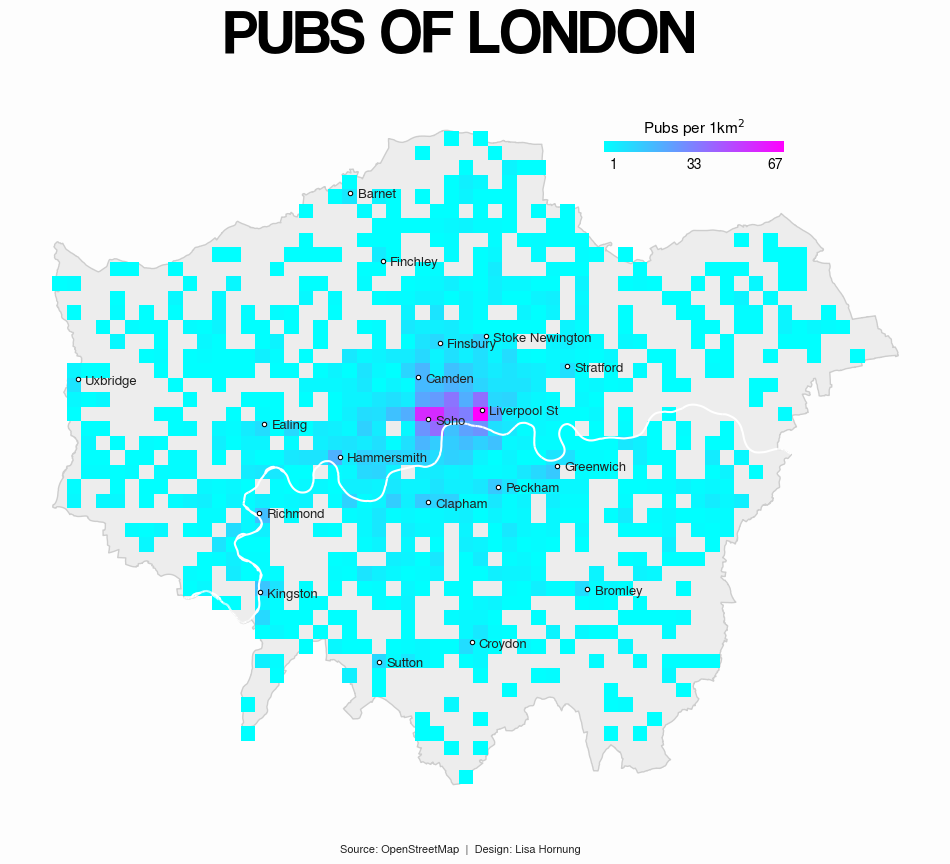

In [180]:
# setup ----------------------
fig, ax = plt.subplots(figsize=(12, 10))
bg_color='#FDFDFD'
fig.set_facecolor(bg_color)

# plot data -----------------------
values = 'pubs'
fishnet.plot(ax=ax, column=values, alpha=1, zorder=2, cmap='cool')
london_all.plot(ax=ax, zorder=1, color='#EDEDED', edgecolor='#CDCDCD')
river.plot(ax=ax, color='white')
places.plot(ax=ax, markersize=10,zorder=2, color='white', edgecolor='black', linewidth=0.75)
for i in range(len(places)):
    ax.text(places['geometry'].iloc[i].x+500, places['geometry'].iloc[i].y, places.index[i],
            va='center_baseline', ha='left', fontsize=9.5, color='#222222')
ax.axis('off')

# colorbar ---------------------------
cbaxes = fig.add_axes([0.62, 0.8, 0.15, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap='cool')              
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', 
                  drawedges=False,ticks=[0.05,0.5, 0.95])
cb.set_ticklabels(['1',int(fishnet[values].max()/2), int(fishnet[values].max())])
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)
cbaxes.text(0.5, 1.7, r'Pubs per 1km$^2$', ha='center', size=11, )

# title and footer -------------------
plt.figtext(0.5, 0.9 , 'Pubs of London'.upper(), fontproperties=title_font, fontsize=45,  ha='center')
plt.figtext(0.5, 0.1, 'Source: OpenStreetMap  |  Design: Lisa Hornung', fontsize=8, ha='center', color='#222222')

#save ----------------------
plt.savefig('london-pubs-1skm.png', bbox_inches='tight', pad_inches=1, facecolor=bg_color, dpi=120)

plt.show()

## Playground

In [ ]:
# get pubs from OSM using Overpass API
overpass_url = 'http://overpass-api.de/api/interpreter'
overpass_query = '''
[out:json];
area[name='United Kingdom'][admin_level=2]->.searchArea;

(way['amenity'='pub'](area.searchArea);  
node['amenity'='pub'](area.searchArea);  
rel['amenity'='pub'](area.searchArea); 
);
out center;

'''
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()